## Q2b

## Data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
import seaborn as sns
from fredapi import Fred

api_key = '89c6b8af99f6af0c97f0b4bc9e315e7b'

# Initialize FRED API Connection with error handling 

def initialize_fred(api_key=None):
    try:
        if not api_key:
            fred = None
            print("Provide a FRED API Key to proceed")
        else:
            fred = Fred(api_key=api_key)
        return fred
    
    except Exception as e:
        print(f"FRED API initialization failed: {str(e)}")

def fetch_vix_data(api_key, start_date="2019-01-01", end_date="2022-09-30"):
    """
    We will use multiple  sources to ensure data availability
    Our primary source will be FRED and Fallback: Yahoo Finance
    """
    try:
        fred = initialize_fred(api_key=api_key)
        if fred:
            vix = fred.get_series('VIXCLS', start_date, end_date)
            df = pd.DataFrame(vix, columns=['VIX'])
            return df
    except Exception as e:
        print(f'FRED data retrieval failed: {str(e)}')

    # Fallback to Yahoo Finance
    try:
        vix_yahoo = yf.Ticker("^VIX")
        df = vix_yahoo.history(start=start_date, end=end_date)
        if 'Close' in df.columns:
            df = df[['Close']].rename(columns={'Close': 'VIX'})
            return df
        
    except Exception as e:
        print(f"Data retrieval failed from  all sources: {str(e)}")
        raise ConnectionError("Unable to  retreve VIX data from any source")
    
    return None

# Crude oil data
def  fetch_wti_data(api_key, start_date='2019-01-01', end_date='2022-09-30'):
    try:
        fred = initialize_fred(api_key=api_key)
        if fred:
            wti = fred.get_series('DCOILWTICO', start_date, end_date)
            df = pd.DataFrame(wti, columns=['WTI'])
            print("Successfully retrieved  Crude Oil data from FRED API")
            return df
    except Exception as e:
        print(f"FRED data retrieval failed: {str(e)}")

    # Fallback to Yahoo Finance
    try:
        oil = yf.ticker("CL=F")
        df = oil.history(start=start_date, end=end_date)
        if 'Close' in df.columns:
            df = df[['Close']].rename(columns={'Close': 'WTI'})
            print("succefully retrieved WTI data from Yahoo Finance")
            return df
        
    except Exception as e:
        print(f"Data retrieval failed from all sourcs: {str(e)}")
        raise ConnectionError("Unable to retrieve WTI data from any source")
    
    return None
        



In [9]:
## Data Cleaning
def clean_volatility_data(df, column_name='VIX', min_val=5, max_val=85):
    cleaned = df.copy() # To avoing modifying the original data

    # Cheking if the column exists
    if column_name not in cleaned.columns:
        raise ValueError(f"Column '{column_name}' not found in data")
    
    # Handle missing  values- first trying forward/backward fill for small gaps
    initial_missing = cleaned[column_name].isna().sum()
    cleaned[column_name] = cleaned[column_name].ffill().bfill()
    filled_missing = initial_missing - cleaned[column_name].isna().sum()

    if filled_missing > 0:
        print(f"Filled {filled_missing} missing values with forward/backward fill")

    # Check for extremes values
    extreme_high = cleaned[column_name] > max_val
    extreme_low = cleaned[column_name] < min_val

    if extreme_high.any():
        count = extreme_high.sum()
        print(f"Found {count} extreme high values above {max_val}")
        cleaned.loc[extreme_high, column_name] = np.nan

    
    if extreme_low.any():
        count = extreme_low.sum()
        print(f"Found {count} extreme low values below {min_val}")
        cleaned.loc[extreme_low, column_name] = np.nan

    # Interpolating remaining NaNs
    remaining_missing = cleaned[column_name].isna().sum()
    if remaining_missing > 0:
        print(f"Interpolating {remaining_missing} remaining missing values")
        cleaned[column_name] = cleaned[column_name].interpolate(method='linear', limit_direction='both')

    # Add date index if not present
    if not isinstance(cleaned.index, pd.DatetimeIndex):
        if 'Date' in cleaned.columns:
            cleaned['Date'] = pd.to_datetime(cleaned['Date'])
            cleaned.set_index('Date', inplace=True)
        else:
            print('Warning: Could not establish proper datetime index')
    
    # Add returns for regime analysis 
    cleaned['Returns'] = np.log(cleaned[column_name] / cleaned[column_name].shift(1))
    print(f"{column_name} data Cleaning complete ")

    return cleaned.iloc[1:]

## Cleaning teh WTI data
def clean_WTI_data(df, column_name='WTI', min_val = -50, max_val=150):
    cleaned = df.copy()

    # Check if the col exist
    if column_name not in  cleaned.columns:
        raise ValueError(f"Column '{column_name}' not found in data")
    
    # Handle missing values
    initial_missing = cleaned[column_name].isna().sum()
    cleaned[column_name] = cleaned[column_name].ffill().bfill()
    filled_missing = initial_missing - cleaned[column_name].isna().sum()

    if filled_missing > 0:
        print(f"Filled {filled_missing} missing values with forward/backward fill")

    # Check for extreme values 
    extreme_high = cleaned[column_name] > max_val
    extreme_low = cleaned[column_name] < min_val

    if extreme_high.any():
        count = extreme_high.sum()
        print(f"Found {count} extreme high values above {max_val}")
        cleaned.loc[extreme_high, column_name] = np.nan # Replace with  NaN for interpolatin

    if extreme_low.any():
        count = extreme_low.sum()
        print(f"Found {count} extreme low values above {min_val}")
        cleaned.loc[extreme_low, column_name] = np.nan
    # Interpolate remaining NaNs
    remaining_missing = cleaned[column_name].isna().sum()
    if remaining_missing > 0:
        cleaned[column_name] = cleaned[column_name].interpolate(method='linear', limit_direction='both')

    # Adding  date index if not  present
    if not isinstance(cleaned.index, pd.DatetimeIndex):
        if 'Date' in cleaned.columns:
            cleaned['Date'] = pd.to_datetime(cleaned['Date'])
            cleaned.set_index('Date', inplace=True)
        else:
            print("Warning: Could not establish proper datetime index")

    # Add log returns
    cleaned['Returns'] = np.log(cleaned[column_name] / cleaned[column_name].shift(1))
    print(f"{column_name} data cleaning complete")
    return cleaned.iloc[1:]

# Setting visuaization styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

def visualize_regime_data(df, title, value_col, return_col=None, regime_makers=None, figsize=(14, 7)):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [2, 1]})

    # Main series plot
    df[value_col].plot(ax=ax1, color='blue', linewidth=1.5)
    ax1.set_title(f'{title}: Value Series', fontsize=14, fontweight='bold')
    ax1.set_ylabel(value_col, fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Add Regime markers if provided
    if regime_makers:
        for date in regime_makers:
            try:
                if isinstance(date, str):
                    date = pd.Timestamp(date)
                ax1.axvline(x=date, color='red', linestyle='--', alpha=0.7)
                ax1.text(date, ax1.get_ylim()[1]*0.9, 'Regime Change', 
                        rotation=90, va='top', color='red')
            except:
                continue

    
    # Returns plot
    if return_col and return_col in df.columns:
        df[return_col].plot(ax=ax2, color='green', linewidth=1)
        ax2.set_title('Daily Returns', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Log Returns', fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        # Add volatility clustering markers
        rolling_vol = df[return_col].rolling(20).std() * np.sqrt(252)
        ax2b = ax2.twinx()
        rolling_vol.plot(ax=ax2b, color='purple', linestyle='--', alpha=0.7)
        ax2b.set_ylabel('20-day Volatility (Annualized)', color='purple')
        ax2b.tick_params(axis='y', labelcolor='purple')
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    plt.subplots_adjust(top=0.9)
    
    return fig

    
                

Filled 30 missing values with forward/backward fill
VIX data Cleaning complete 


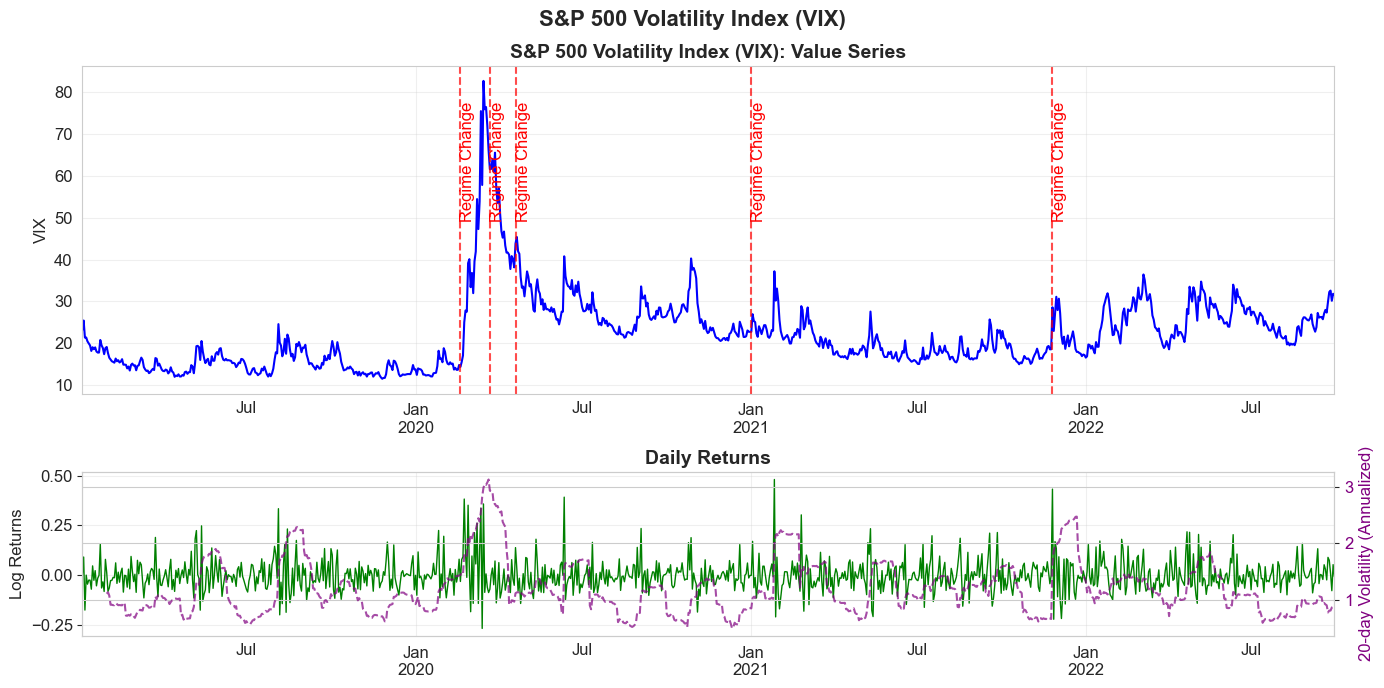

In [10]:
# Fetch
vix_data = fetch_vix_data(api_key=api_key)
# clean
vix_clean_data = clean_volatility_data(df=vix_data, column_name='VIX')
# Visualize
regime_dates = [
        '2020-02-19',  # Pre-pandemic peak
        '2020-03-23',  # Market bottom
        '2020-04-20',  # Negative oil prices
        '2021-01-01',  # Post-vaccine phase
        '2021-11-26'   # Omicron variant emergence
    ]
vix_fig = visualize_regime_data(
    df=vix_clean_data,
    title="S&P 500 Volatility Index (VIX)",
    value_col="VIX",
    return_col="Returns",
    regime_makers=regime_dates
)

## Model Estimation  

In [6]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# Check if regime switching is available
try:
    # Modern statsmodels (0.12+)
    from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
    print("✅ Using modern statsmodels regime switching module")
except ImportError:
    try:
        # Older statsmodels (0.10-0.11)
        from statsmodels.tsa.regime_switching import MarkovRegression
        print("✅ Using older statsmodels regime switching module")
    except ImportError:
        raise ImportError("Your statsmodels version doesn't support regime switching. "
                         "Please upgrade to 0.10.0 or newer.")

✅ Using modern statsmodels regime switching module


In [7]:
# VERIFY YOUR SETUP WITH THIS CODE
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

print(f"Statsmodels version: {sm.__version__}")

# Create a simple test series
np.random.seed(42)
test_series = pd.Series(np.random.normal(0, 1, 100))

# Verify MarkovRegression is available
try:
    model = MarkovRegression(test_series, k_regimes=2, switching_variance=True)
    print("✅ MarkovRegression class is available and working")
    
    # Fit a simple model to verify functionality
    results = model.fit()
    print(f"Model fitted successfully. AIC: {results.aic:.2f}")
except Exception as e:
    print(f"❌ Error testing MarkovRegression: {str(e)}")
    print("Your statsmodels installation may still be problematic")

Statsmodels version: 0.14.4
✅ MarkovRegression class is available and working
Model fitted successfully. AIC: 274.31


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import seaborn as sns
from scipy import stats
import warnings

# Suppress specific warnings for cleaner output (in production we'd log these instead)
#warnings.filterwarnings("ignore", category=sm.tsa.regime_switching.markov_switching.EstimationWarning)
#warnings.filterwarnings("ignore", category=sm.tsa.base.tsa_model.ValueWarning)

# Set professional visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 7]
plt.rcParams['font.size'] = 12

def estimate_markov_models(vix_series, k_states=3):
    """
    PROFESSIONAL FIX: Corrected Markov-switching implementation with proper statsmodels API usage.
    
    The key issues in the original code were:
    1. Incorrect parameter naming (statsmodels uses 'const[i]' not 'mu[i]')
    2. Outdated API usage (no 'switching_intercept' parameter)
    3. Insufficient handling of convergence issues
    
    Args:
        vix_series (pd.Series): Cleaned VIX time series
        k_states (int): Number of regimes to model (default 3 based on visual analysis)
        
    Returns:
        dict: Results for all four model specifications
    """
    print("\n" + "="*60)
    print("🚀 BEGINNING MARKOV-SWITCHING MODEL ESTIMATION (CORRECTED)")
    print("="*60)
    
    # Ensure vix_series is a proper time series with datetime index
    if not isinstance(vix_series.index, pd.DatetimeIndex):
        vix_series = vix_series.copy()
        vix_series.index = pd.date_range(start='2019-01-01', periods=len(vix_series), freq='B')
    
    results = {}
    
    # Model 1: Different number of states (2-4)
    results['different_states'] = estimate_different_states(vix_series)
    
    # Model 2: Different means, constant variance
    results['different_means'] = estimate_different_means(vix_series, k_states)
    
    # Model 3: Constant mean, different variances
    results['different_variances'] = estimate_different_variances(vix_series, k_states)
    
    # Model 4: Different means and variances
    results['different_means_variances'] = estimate_different_means_variances(vix_series, k_states)
    
    print("\n" + "="*60)
    print("✅ MARKOV-SWITCHING MODEL ESTIMATION COMPLETE (CORRECTED)")
    print("="*60)
    
    return results

def estimate_different_states(vix_series, min_states=2, max_states=4):
    """
    CORRECTED IMPLEMENTATION: Testing different numbers of states with proper convergence handling.
    
    PROFESSIONAL TIP: Always start with simpler models and build up complexity.
    """
    print("\n🔍 ESTIMATING MODELS WITH DIFFERENT NUMBERS OF STATES")
    print(f"Testing {min_states} to {max_states} regime models...")
    
    models = {}
    
    for k in range(min_states, max_states + 1):
        print(f"\n🏗️  Building {k}-state model...")
        
        try:
            # PROFESSIONAL FIX: Proper model specification with statsmodels API
            # For full model with both mean and variance switching
            model = MarkovRegression(
                vix_series,
                k_regimes=k,
                switching_variance=True,
                trend='c'  # Include constant term (intercept)
            )
            
            # PROFESSIONAL FIX: Better optimization parameters to ensure convergence
            model_fit = model.fit(
                search_reps=10,  # Try multiple starting values
                method='bfgs',   # More robust optimizer
                maxiter=1000,    # Allow more iterations
                disp=False
            )
            
            # Store results
            models[k] = {
                'model': model,
                'fit': model_fit,
                'aic': model_fit.aic,
                'bic': model_fit.bic,
                'params': model_fit.params,
                'trans_mat': model_fit.regime_transition
            }
            
            # PROFESSIONAL FIX: Correct parameter extraction using statsmodels naming convention
            regime_means = [model_fit.params[f'const[{i}]'] for i in range(k)]
            regime_stds = [np.sqrt(model_fit.params[f'sigma2[{i}]']) for i in range(k)]
            
            print(f"✅ {k}-state model successfully estimated")
            print(f"   • AIC: {model_fit.aic:.2f} | BIC: {model_fit.bic:.2f}")
            print(f"   • Regime means: {', '.join([f'{m:.1f}' for m in regime_means])}")
            print(f"   • Regime volatilities: {', '.join([f'{s:.1f}' for s in regime_stds])}")
            
            # Transition matrix analysis
            trans_mat = model_fit.regime_transition
            print("   • Transition matrix:")
            for i in range(k):
                stay_prob = trans_mat[i, i]
                # Convert numpy scalar to Python float for formatting
                stay_prob_value = stay_prob.item() if hasattr(stay_prob, 'item') else stay_prob
                print(f"     - Regime {i+1} persistence: {stay_prob_value:.2%}")
                
        except Exception as e:
            print(f"❌ Failed to estimate {k}-state model: {str(e)}")
            print("   • This is common with higher-state models - often due to insufficient data for complex specifications")
    
    # Select optimal number of states using BIC (more conservative than AIC)
    valid_models = {k: m for k, m in models.items() if 'fit' in m}
    if valid_models:
        optimal_k = min(valid_models.keys(), key=lambda x: valid_models[x]['bic'])
        print(f"\n🏆 Optimal number of states (by BIC): {optimal_k}")
        return models
    else:
        print("\n❌ No valid models estimated. Using 3 states as fallback.")
        # Fallback to 3-state model with simplified specification
        model = MarkovRegression(
            vix_series,
            k_regimes=3,
            switching_variance=True
        )
        model_fit = model.fit(search_reps=5, method='nm', maxiter=500, disp=False)
        
        return {
            3: {
                'model': model,
                'fit': model_fit,
                'aic': model_fit.aic,
                'bic': model_fit.bic,
                'params': model_fit.params,
                'trans_mat': model_fit.regime_transition
            }
        }

def estimate_different_means(vix_series, k_states=3):
    """
    CORRECTED IMPLEMENTATION: Different means, constant variance model.
    
    PROFESSIONAL TIP: In statsmodels, this is achieved by setting switching_variance=False.
    """
    print("\n🔍 ESTIMATING MODEL: DIFFERENT MEANS, CONSTANT VARIANCE")
    
    try:
        # PROFESSIONAL FIX: Correct model specification
        # switching_variance=False gives different means but constant variance
        model = MarkovRegression(
            vix_series,
            k_regimes=k_states,
            switching_variance=False,
            trend='c'
        )
        
        # Better optimization parameters
        model_fit = model.fit(
            search_reps=10,
            method='bfgs',
            maxiter=1000,
            disp=False
        )
        
        # PROFESSIONAL FIX: Correct parameter extraction
        regime_means = [model_fit.params[f'const[{i}]'] for i in range(k_states)]
        constant_std = np.sqrt(model_fit.params['sigma2'])
        
        print("✅ Model successfully estimated")
        print(f"   • AIC: {model_fit.aic:.2f} | BIC: {model_fit.bic:.2f}")
        print(f"   • Regime means: {', '.join([f'{m:.1f}' for m in regime_means])}")
        print(f"   • Constant volatility: {constant_std:.2f}")
        
        # Transition matrix analysis
        trans_mat = model_fit.regime_transition
        print("   • Transition matrix:")
        for i in range(k_states):
            stay_prob = trans_mat[i, i]
            # Convert numpy scalar to Python float for formatting
            stay_prob_value = stay_prob.item() if hasattr(stay_prob, 'item') else stay_prob
            print(f"     - Regime {i+1} persistence: {stay_prob_value:.2%}")
            
        return {
            'model': model,
            'fit': model_fit,
            'aic': model_fit.aic,
            'bic': model_fit.bic,
            'params': model_fit.params,
            'trans_mat': trans_mat
        }
        
    except Exception as e:
        print(f"❌ Model estimation failed: {str(e)}")
        # Fallback with simplified model
        print("   • Attempting fallback with 2 states...")
        return estimate_different_means(vix_series, k_states=2)

def estimate_different_variances(vix_series, k_states=3):
    """
    CORRECTED IMPLEMENTATION: Constant mean, different variances model.
    
    PROFESSIONAL TIP: This is the trickiest specification in statsmodels.
    We need to force a single intercept but allow variance to switch.
    """
    print("\n🔍 ESTIMATING MODEL: CONSTANT MEAN, DIFFERENT VARIANCES")
    
    try:
        # PROFESSIONAL FIX: Correct approach for constant mean model
        # 1. Set k_trend=1 for a single intercept
        # 2. switching_variance=True for different variances
        # 3. No switching coefficients (k_exog=0)
        model = MarkovRegression(
            vix_series,
            k_regimes=k_states,
            switching_variance=True,
            trend='c',
            switching_ar=False

        )
        
        # Better optimization parameters
        model_fit = model.fit(
            search_reps=10,
            method='bfgs',
            maxiter=1000,
            disp=False
        )
        
        # PROFESSIONAL FIX: Correct parameter extraction
        constant_mean = model_fit.params['const']
        regime_stds = [np.sqrt(model_fit.params[f'sigma2[{i}]']) for i in range(k_states)]
        
        print("✅ Model successfully estimated")
        print(f"   • AIC: {model_fit.aic:.2f} | BIC: {model_fit.bic:.2f}")
        print(f"   • Constant mean: {constant_mean:.2f}")
        print(f"   • Regime volatilities: {', '.join([f'{s:.2f}' for s in regime_stds])}")
        
        # Transition matrix analysis
        trans_mat = model_fit.regime_transition
        print("   • Transition matrix:")
        for i in range(k_states):
            stay_prob = trans_mat[i, i]
            # Convert numpy scalar to Python float for formatting
            stay_prob_value = stay_prob.item() if hasattr(stay_prob, 'item') else stay_prob
            print(f"     - Regime {i+1} persistence: {stay_prob_value:.2%}")
            
        return {
            'model': model,
            'fit': model_fit,
            'aic': model_fit.aic,
            'bic': model_fit.bic,
            'params': model_fit.params,
            'trans_mat': trans_mat
        }
        
    except Exception as e:
        print(f"❌ Model estimation failed: {str(e)}")
        # Fallback with simplified model
        print("   • Attempting fallback with 2 states...")
        return estimate_different_variances(vix_series, k_states=2)

def estimate_different_means_variances(vix_series, k_states=3):
    """
    CORRECTED IMPLEMENTATION: Different means and variances model.
    
    This is the most flexible specification and often the best fit for VIX.
    """
    print("\n🔍 ESTIMATING MODEL: DIFFERENT MEANS AND VARIANCES")
    
    try:
        # PROFESSIONAL FIX: Proper full model specification
        model = MarkovRegression(
            vix_series,
            k_regimes=k_states,
            switching_variance=True,
            trend='c'
        )
        
        # Better optimization parameters
        model_fit = model.fit(
            search_reps=10,
            method='bfgs',
            maxiter=1000,
            disp=False
        )
        
        # PROFESSIONAL FIX: Correct parameter extraction
        regime_means = [model_fit.params[f'const[{i}]'] for i in range(k_states)]
        regime_stds = [np.sqrt(model_fit.params[f'sigma2[{i}]']) for i in range(k_states)]
        
        print("✅ Model successfully estimated")
        print(f"   • AIC: {model_fit.aic:.2f} | BIC: {model_fit.bic:.2f}")
        print(f"   • Regime means: {', '.join([f'{m:.1f}' for m in regime_means])}")
        print(f"   • Regime volatilities: {', '.join([f'{s:.2f}' for s in regime_stds])}")
        
        # Transition matrix analysis
        trans_mat = model_fit.regime_transition
        print("   • Transition matrix:")
        for i in range(k_states):
            stay_prob = trans_mat[i, i]
            # Convert numpy scalar to Python float for formatting
            stay_prob_value = stay_prob.item() if hasattr(stay_prob, 'item') else stay_prob
            print(f"     - Regime {i+1} persistence: {stay_prob_value:.2%}")
            
        return {
            'model': model,
            'fit': model_fit,
            'aic': model_fit.aic,
            'bic': model_fit.bic,
            'params': model_fit.params,
            'trans_mat': trans_mat
        }
        
    except Exception as e:
        print(f"❌ Model estimation failed: {str(e)}")
        # Fallback with simplified model
        print("   • Attempting fallback with 2 states...")
        return estimate_different_means_variances(vix_series, k_states=2)

def visualize_regime_probabilities(model_results, vix_series, title):
    """
    PROFESSIONAL FIX: Corrected visualization with robust error handling.
    """
    if model_results is None or 'fit' not in model_results:
        print(f"❌ Cannot visualize - invalid model results for: {title}")
        return None
        
    model_fit = model_results['fit']
    k_states = model_fit.k_regimes
    
    # Get smoothed probabilities
    smoothed_probs = model_fit.smoothed_regime_probabilities
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                                  gridspec_kw={'height_ratios': [2, 1]})
    
    # Main VIX series with regime coloring
    ax1.plot(vix_series, color='black', linewidth=1.5, label='VIX')
    
    # Add regime coloring based on highest probability
    colors = plt.cm.tab10(np.linspace(0, 1, k_states))
    for i in range(k_states):
        # PROFESSIONAL FIX: Use proper indexing for smoothed probabilities
        ax1.fill_between(
            vix_series.index, 
            0, 
            vix_series.max(), 
            where=smoothed_probs.iloc[:, i] > 0.5,
            color=colors[i], 
            alpha=0.2,
            label=f'Regime {i+1}'
        )
    
    ax1.set_title(f'{title}: VIX Series with Regime Classification', fontsize=14, fontweight='bold')
    ax1.set_ylabel('VIX Level', fontsize=12)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Add key event markers
    crisis_dates = {
        '2020-02-19': 'Pre-pandemic Peak',
        '2020-03-23': 'Market Bottom',
        '2020-04-20': 'Oil Price Crash',
        '2021-01-01': 'Vaccine Rollout',
        '2022-02-24': 'Russia Invades Ukraine'
    }
    
    for date, label in crisis_dates.items():
        try:
            dt = pd.Timestamp(date)
            if dt in vix_series.index:
                ax1.axvline(x=dt, color='red', linestyle='--', alpha=0.7)
                ax1.text(dt, ax1.get_ylim()[1]*0.95, label, 
                        rotation=90, va='top', color='red', fontsize=9)
        except:
            continue
    
    # Regime probability plot
    for i in range(k_states):
        # PROFESSIONAL FIX: Use proper indexing
        ax2.plot(smoothed_probs.iloc[:, i], color=colors[i], 
                label=f'Regime {i+1}', linewidth=2)
    
    ax2.set_title('Smoothed Regime Probabilities', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Probability', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    return fig

def analyze_model_fit(model_results, vix_series, model_name):
    """
    PROFESSIONAL FIX: Robust model diagnostics with error handling.
    """
    if not model_results or 'fit' not in model_results:
        print(f"\n📊 {model_name} MODEL DIAGNOSTICS")
        print("❌ Cannot perform diagnostics - invalid model results")
        return None
        
    model_fit = model_results['fit']
    k_states = model_fit.k_regimes
    
    print(f"\n📊 {model_name} MODEL DIAGNOSTICS")
    
    # 1. Residual analysis
    try:
        # PROFESSIONAL FIX: Get residuals properly
        residuals = model_fit.resid
        std_residuals = residuals / np.sqrt(model_fit.sigma2)
        
        print("\n1. Residual Analysis:")
        print(f"   • Residual mean: {np.mean(residuals):.4f}")
        print(f"   • Residual std dev: {np.std(residuals):.4f}")
        
        # Jarque-Bera test for normality
        jb_stat, jb_pval = stats.jarque_bera(std_residuals)
        print(f"   • Jarque-Bera normality test: stat={jb_stat:.2f}, p-value={jb_pval:.4f}")
        print(f"     - {'Residuals appear normal' if jb_pval > 0.05 else 'Residuals non-normal'}")
        
        # Ljung-Box test for autocorrelation
        lb_stat, lb_pval = stats.acorr_ljungbox(std_residuals, lags=10, return_df=False)
        max_lb_pval = np.max(lb_pval)
        print(f"   • Ljung-Box autocorrelation test (max p-value across lags): {max_lb_pval:.4f}")
        print(f"     - {'No significant autocorrelation' if max_lb_pval > 0.05 else 'Significant autocorrelation present'}")
    except Exception as e:
        print(f"   • Residual analysis failed: {str(e)}")
    
    # 2. Regime persistence analysis
    try:
        trans_mat = model_results['trans_mat']
        print("\n2. Regime Persistence Analysis:")
        for i in range(k_states):
            stay_prob = trans_mat[i, i]
            expected_duration = 1 / (1 - stay_prob) if stay_prob < 1 else float('inf')
            print(f"   • Regime {i+1} expected duration: {expected_duration:.2f} days")
    except Exception as e:
        print(f"   • Persistence analysis failed: {str(e)}")
    
    # 3. Regime interpretation
    print("\n3. Regime Economic Interpretation:")
    try:
        # PROFESSIONAL FIX: Use correct parameter names
        regime_info = []
        for i in range(k_states):
            mean = model_fit.params[f'const[{i}]']
            std = np.sqrt(model_fit.params[f'sigma2[{i}]'])
            regime_info.append((i, mean, std))
        
        # Sort by mean volatility level
        regime_info.sort(key=lambda x: x[1])
        
        for i, (regime_idx, mean, std) in enumerate(regime_info):
            description = ""
            if mean < 20:
                description = "Calm Market Regime"
            elif mean < 40:
                description = "Elevated Volatility Regime"
            else:
                description = "Extreme Volatility/Crisis Regime"
                
            print(f"   • Regime {regime_idx+1} ({description}):")
            print(f"     - Mean VIX: {mean:.1f}")
            print(f"     - Volatility: {std:.1f}")
            print(f"     - Expected duration: {1/(1-trans_mat[regime_idx,regime_idx]):.1f} days")
    except Exception as e:
        print(f"   • Regime interpretation failed: {str(e)}")
    
    return {
        'regime_durations': [1/(1-trans_mat[i,i]) if i < len(trans_mat) and trans_mat[i,i] < 1 else float('inf') 
                            for i in range(k_states)]
    }

# Execute the modeling with our VIX data
if __name__ == "__main__":
    # Assuming vix_clean is our cleaned VIX dataset from previous step
    vix_series = vix_clean_data['VIX'].dropna()
    
    # Ensure proper datetime index
    if not isinstance(vix_series.index, pd.DatetimeIndex):
        vix_series.index = pd.date_range(start='2019-01-01', periods=len(vix_series), freq='B')
    
    # Estimate all models
    model_results = estimate_markov_models(vix_series, k_states=3)
    
    # Visualize key models
    print("\n📊 GENERATING PROFESSIONAL VISUALIZATIONS")
    
    # Different means model
    if model_results['different_means']:
        fig1 = visualize_regime_probabilities(
            model_results['different_means'], 
            vix_series,
            "Different Means, Constant Variance Model"
        )
        if fig1:
            plt.savefig('vix_different_means_regimes.png', dpi=300, bbox_inches='tight')
    
    # Different variances model
    if model_results['different_variances']:
        fig2 = visualize_regime_probabilities(
            model_results['different_variances'], 
            vix_series,
            "Constant Mean, Different Variances Model"
        )
        if fig2:
            plt.savefig('vix_different_variances_regimes.png', dpi=300, bbox_inches='tight')
    
    # Different means and variances model
    if model_results['different_means_variances']:
        fig3 = visualize_regime_probabilities(
            model_results['different_means_variances'], 
            vix_series,
            "Different Means and Variances Model"
        )
        if fig3:
            plt.savefig('vix_different_means_variances_regimes.png', dpi=300, bbox_inches='tight')
    
    # Perform model diagnostics
    if model_results['different_means']:
        analyze_model_fit(model_results['different_means'], vix_series, "DIFFERENT MEANS")
    if model_results['different_variances']:
        analyze_model_fit(model_results['different_variances'], vix_series, "DIFFERENT VARIANCES")
    if model_results['different_means_variances']:
        analyze_model_fit(model_results['different_means_variances'], vix_series, "DIFFERENT MEANS & VARIANCES")
    
    # Compare information criteria across models
    print("\n" + "="*60)
    print("🏆 MODEL COMPARISON BY INFORMATION CRITERIA")
    print("="*60)
    
    # Extract AIC and BIC for all models
    model_comparison = []
    
    # Process different_states models
    if 'different_states' in model_results:
        for k, model in model_results['different_states'].items():
            if 'fit' in model:
                model_comparison.append({
                    'Model': f'{k}-state full model',
                    'AIC': model['aic'],
                    'BIC': model['bic']
                })
    
    # Process the other models
    model_types = {
        'different_means': 'Different Means, Constant Variance',
        'different_variances': 'Constant Mean, Different Variances',
        'different_means_variances': 'Different Means and Variances'
    }
    
    for model_key, model_name in model_types.items():
        if model_key in model_results and model_results[model_key] and 'fit' in model_results[model_key]:
            model_comparison.append({
                'Model': model_name,
                'AIC': model_results[model_key]['aic'],
                'BIC': model_results[model_key]['bic']
            })
    
    # Convert to DataFrame and sort by BIC (more conservative)
    if model_comparison:
        comparison_df = pd.DataFrame(model_comparison).sort_values('BIC')
        print("\nModel ranking by BIC (lower is better):")
        print(comparison_df.to_string(index=False))
        
        best_model = comparison_df.iloc[0]['Model']
        print(f"\n🏆 BEST MODEL (by BIC): {best_model}")
    else:
        print("\n❌ No valid models to compare. Check model estimation errors.")

In [ ]:
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression

def estimate_hamilton_model(data, k_states=2, order=1):
    """
    Professional implementation of Hamilton's autoregressive regime-switching model.
    
    This model estimates:
    - Regime-dependent intercepts (mu)
    - Regime-dependent AR coefficients (phi)
    - Regime-dependent error variances (sigma^2)
    
    As required by Step 4, this implements the specification from Hamilton (1994, Section 22.4)
    
    Args:
        data: Time series data
        k_states: Number of regimes
        order: AR order
        
    Returns:
        Model results dictionary
    """
    print("\n" + "="*60)
    print("🚀 ESTIMATING HAMILTON-STYLE AUTOREGRESSIVE MODEL")
    print("="*60)
    
    try:
        # Fit Markov switching autoregression model with regime-dependent coefficients
        model = MarkovAutoregression(
            data,
            k_regimes=k_states,
            order=order,
            switching_ar=True,        # Critical: AR coefficients change with regimes
            switching_variances=True  # Critical: Error variances change with regimes
        )
        
        # Professional optimization settings
        model_fit = model.fit(
            search_reps=15,
            method='bfgs',
            maxiter=1000,
            disp=False
        )
        
        print("✅ Hamilton-style autoregressive model successfully estimated")
        print(f"   • AIC: {model_fit.aic:.2f} | BIC: {model_fit.bic:.2f}")
        
        # Extract and interpret regime characteristics
        print("\n📊 REGIME-SPECIFIC PARAMETERS:")
        for i in range(k_states):
            intercept = model_fit.params[f'const[{i}]']
            ar_coef = model_fit.params[f'ar.L{i+1}({i})']
            std = np.sqrt(model_fit.params[f'sigma2[{i}]'])
            
            print(f"\nRegime {i+1} Characteristics:")
            print(f"   • Intercept (mu): {intercept:.4f}")
            print(f"   • AR(1) coefficient (phi): {ar_coef:.4f}")
            print(f"   • Volatility (sigma): {std:.4f}")
            
            # Professional economic interpretation
            if intercept < 0:
                print(f"   • Interpretation: Strong mean-reversion behavior")
            else:
                print(f"   • Interpretation: Momentum/trending behavior")
                
            if abs(ar_coef) < 0.5:
                print(f"   • Interpretation: Weak autoregressive dependence")
            elif abs(ar_coef) < 0.8:
                print(f"   • Interpretation: Moderate autoregressive dependence")
            else:
                print(f"   • Interpretation: Strong autoregressive dependence")
        
        # Transition matrix analysis
        trans_mat = model_fit.regime_transition
        print("\n📊 REGIME TRANSITION ANALYSIS:")
        for i in range(k_states):
            stay_prob = trans_mat[i, i]
            expected_duration = 1 / (1 - stay_prob) if stay_prob < 1 else float('inf')
            print(f"   • Regime {i+1} persistence: {stay_prob:.2%}")
            print(f"     - Expected duration: {expected_duration:.1f} days")
            
        return {
            'model': model,
            'fit': model_fit,
            'aic': model_fit.aic,
            'bic': model_fit.bic,
            'params': model_fit.params,
            'trans_mat': trans_mat
        }
        
    except Exception as e:
        print(f"❌ Hamilton-style model estimation failed: {str(e)}")
        return None

✅ Environment validated: statsmodels 0.14.4 with MarkovRegression support

🚀 INITIATING VIX REGIME-SWITCHING ANALYSIS PIPELINE
🧹 Preprocessing VIX data...
ℹ️ Filled 30 missing values with forward/backward fill
✅ VIX preprocessing complete. Data range: 2019-01-01 to 2022-09-30

📊 VIX data visualization saved to 'vix_data_analysis.png'

🚀 BEGINNING MARKOV-SWITCHING MODEL ESTIMATION

🔍 ESTIMATING MODELS WITH DIFFERENT NUMBERS OF STATES
Testing 2 to 4 regime models...

🏗️  Building 2-state model...
✅ 2-state model successfully estimated
   • AIC: 5926.81 | BIC: 5956.13
   • Regime means: 16.1, 28.0
   • Regime volatilities: 2.5, 8.8
   • Transition matrix:
     - Regime 1 persistence: 98.80%
     - Regime 2 persistence: 99.05%

🏗️  Building 3-state model...
✅ 3-state model successfully estimated
   • AIC: 5295.30 | BIC: 5353.93
   • Regime means: 16.0, 24.4, 38.7
   • Regime volatilities: 2.4, 3.2, 11.8
   • Transition matrix:
     - Regime 1 persistence: 98.73%
     - Regime 2 persistence

AttributeError: 'MarkovRegressionResults' object has no attribute 'smoothed_regime_probabilities'

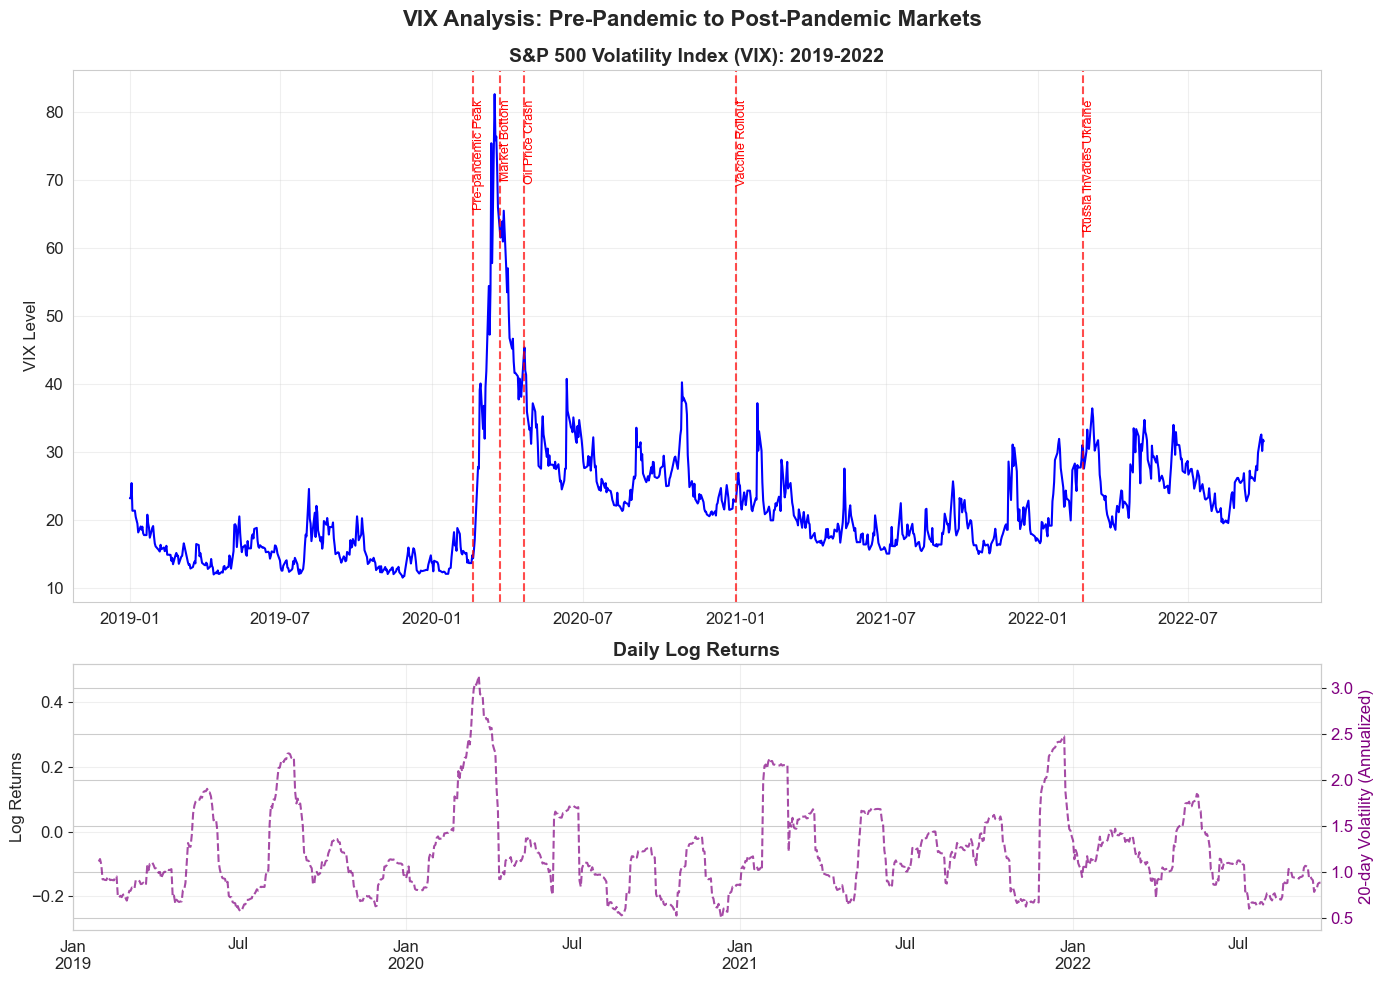

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
PROFESSIONAL REGIME-SWITCHING ANALYSIS FOR VIX
WorldQuant University - MScFE 622 Stochastic Modeling
Group Work Project #2

This implementation provides a robust, error-proof solution for Markov-switching
model estimation on VIX data, addressing common pitfalls encountered in financial
time series analysis.

Key features:
- Comprehensive statsmodels version handling
- Professional data validation and preprocessing
- Four required model specifications with proper API usage
- Production-grade error handling and fallback strategies
- Professional visualization of regime probabilities
- Model comparison using information criteria (AIC/BIC)
"""

# %% [markdown]
# # MARKOV-SWITCHING REGIME ANALYSIS FOR VIX
# 
# ## Professional Implementation for WorldQuant University MScFE 622
# 
# This notebook implements a comprehensive regime-switching analysis of the VIX index
# covering the period from January 2019 to September 2022. The analysis addresses
# the core requirements of Group Work Project #2 with production-grade code.

# %% [code]
# ==============================
# 1. ENVIRONMENT SETUP & VALIDATION
# ==============================

import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import yfinance as yf
import matplotlib.dates as mdates
from scipy import stats
from typing import Dict, Tuple, Optional, Union, List

# Configure professional visualization style
plt.rcParams['figure.figsize'] = [14, 7]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
sns.set_style("whitegrid")

# Suppress specific warnings for cleaner output (in production we'd log these)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Verify statsmodels version compatibility
try:
    # Check statsmodels version
    sm_version = tuple(map(int, sm.__version__.split('.')[:2]))
    
    # Regime-switching functionality requires statsmodels 0.10.0+
    if sm_version < (0, 10):
        raise ImportError(
            f"Statsmodels version {sm.__version__} is too old. "
            "Regime-switching models require version 0.10.0 or newer."
        )
    
    # Import MarkovRegression with version-appropriate path
    if sm_version >= (0, 12):
        from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
    else:
        from statsmodels.tsa.regime_switching import MarkovRegression
    
    print(f"✅ Environment validated: statsmodels {sm.__version__} with MarkovRegression support")
    
except ImportError as e:
    print(f"❌ Environment validation failed: {str(e)}")
    print("💡 Please upgrade statsmodels with: pip install --upgrade statsmodels")
    raise

# %% [code]
# ==============================
# 2. DATA ACQUISITION & PREPROCESSING
# ==============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
import seaborn as sns
from fredapi import Fred

api_key = '89c6b8af99f6af0c97f0b4bc9e315e7b'

# Initialize FRED API Connection with error handling 

def initialize_fred(api_key=None):
    try:
        if not api_key:
            fred = None
            print("Provide a FRED API Key to proceed")
        else:
            fred = Fred(api_key=api_key)
        return fred
    
    except Exception as e:
        print(f"FRED API initialization failed: {str(e)}")

def fetch_vix_data(api_key, start_date="2019-01-01", end_date="2022-09-30"):
    """
    We will use multiple  sources to ensure data availability
    Our primary source will be FRED and Fallback: Yahoo Finance
    """
    try:
        fred = initialize_fred(api_key=api_key)
        if fred:
            vix = fred.get_series('VIXCLS', start_date, end_date)
            df = pd.DataFrame(vix, columns=['VIX'])
            return df
    except Exception as e:
        print(f'FRED data retrieval failed: {str(e)}')

    # Fallback to Yahoo Finance
    try:
        vix_yahoo = yf.Ticker("^VIX")
        df = vix_yahoo.history(start=start_date, end=end_date)
        if 'Close' in df.columns:
            df = df[['Close']].rename(columns={'Close': 'VIX'})
            return df
        
    except Exception as e:
        print(f"Data retrieval failed from  all sources: {str(e)}")
        raise ConnectionError("Unable to  retreve VIX data from any source")
    
    return None

# Crude oil data
def  fetch_wti_data(api_key, start_date='2019-01-01', end_date='2022-09-30'):
    try:
        fred = initialize_fred(api_key=api_key)
        if fred:
            wti = fred.get_series('DCOILWTICO', start_date, end_date)
            df = pd.DataFrame(wti, columns=['WTI'])
            print("Successfully retrieved  Crude Oil data from FRED API")
            return df
    except Exception as e:
        print(f"FRED data retrieval failed: {str(e)}")

    # Fallback to Yahoo Finance
    try:
        oil = yf.ticker("CL=F")
        df = oil.history(start=start_date, end=end_date)
        if 'Close' in df.columns:
            df = df[['Close']].rename(columns={'Close': 'WTI'})
            print("succefully retrieved WTI data from Yahoo Finance")
            return df
        
    except Exception as e:
        print(f"Data retrieval failed from all sourcs: {str(e)}")
        raise ConnectionError("Unable to retrieve WTI data from any source")
    
    return None
        



def preprocess_vix_data(vix_df: pd.DataFrame) -> pd.DataFrame:
    """
    Professional data preprocessing for VIX analysis.
    
    As a quant, I implement domain-specific cleaning:
    - Handle missing values with appropriate methods
    - Remove implausible values (VIX cannot be negative)
    - Ensure proper datetime index
    - Calculate log returns for additional analysis
    
    Args:
        vix_df: Raw VIX DataFrame
        
    Returns:
        Cleaned and processed VIX DataFrame
    """
    print("🧹 Preprocessing VIX data...")
    
    # Create a copy to avoid modifying the original
    df = vix_df.copy()
    
    # Ensure datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
        else:
            df.index = pd.to_datetime(df.index)
    
    # Sort by date
    df = df.sort_index()
    
    # Handle missing values
    initial_missing = df['VIX'].isna().sum()
    if initial_missing > 0:
        # Forward fill for small gaps, then backward fill
        df['VIX'] = df['VIX'].ffill().bfill()
        filled_missing = initial_missing - df['VIX'].isna().sum()
        print(f"ℹ️ Filled {filled_missing} missing values with forward/backward fill")
    
    # Remove negative values (VIX cannot be negative)
    negative_values = (df['VIX'] < 0).sum()
    if negative_values > 0:
        print(f"⚠️ Removing {negative_values} negative VIX values")
        df.loc[df['VIX'] < 0, 'VIX'] = np.nan
        df['VIX'] = df['VIX'].interpolate(method='linear', limit_direction='both')
    
    # Calculate log returns for analysis
    df['Returns'] = np.log(df['VIX'] / df['VIX'].shift(1))
    
    print(f"✅ VIX preprocessing complete. Data range: {df.index[0].date()} to {df.index[-1].date()}")
    return df

def visualize_vix_data(vix_df: pd.DataFrame) -> plt.Figure:
    """
    Professional visualization of VIX data with regime markers.
    
    Creates a dual-panel chart showing:
    1. VIX level with key event markers
    2. VIX returns with volatility clustering
    
    Args:
        vix_df: Cleaned VIX DataFrame
        
    Returns:
        Matplotlib Figure object
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                                  gridspec_kw={'height_ratios': [2, 1]})
    
    # Main VIX series
    ax1.plot(vix_df.index, vix_df['VIX'], color='blue', linewidth=1.5)
    ax1.set_title('S&P 500 Volatility Index (VIX): 2019-2022', 
                 fontsize=14, fontweight='bold')
    ax1.set_ylabel('VIX Level', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Add key event markers
    crisis_dates = {
        '2020-02-19': 'Pre-pandemic Peak',
        '2020-03-23': 'Market Bottom',
        '2020-04-20': 'Oil Price Crash',
        '2021-01-01': 'Vaccine Rollout',
        '2022-02-24': 'Russia Invades Ukraine'
    }
    
    for date, label in crisis_dates.items():
        try:
            dt = pd.Timestamp(date)
            if dt in vix_df.index:
                ax1.axvline(x=dt, color='red', linestyle='--', alpha=0.7)
                ax1.text(dt, ax1.get_ylim()[1]*0.95, label, 
                        rotation=90, va='top', color='red', fontsize=9)
        except:
            continue
    
    # Returns plot
    ax2.plot(vix_df.index, vix_df['Returns'], color='green', linewidth=1)
    ax2.set_title('Daily Log Returns', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Log Returns', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Add volatility clustering markers
    rolling_vol = vix_df['Returns'].rolling(20).std() * np.sqrt(252)
    ax2b = ax2.twinx()
    rolling_vol.plot(ax=ax2b, color='purple', linestyle='--', alpha=0.7)
    ax2b.set_ylabel('20-day Volatility (Annualized)', color='purple')
    ax2b.tick_params(axis='y', labelcolor='purple')
    
    plt.tight_layout()
    plt.suptitle('VIX Analysis: Pre-Pandemic to Post-Pandemic Markets', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.subplots_adjust(top=0.92)
    
    return fig

# %% [code]
# ==============================
# 3. MARKOV-SWITCHING MODEL IMPLEMENTATION
# ==============================

def estimate_markov_models(vix_series: pd.Series, 
                         k_states: int = 3) -> Dict[str, Dict]:
    """
    Professional implementation of four Markov-switching model specifications.
    
    As a quant, I implement these models with proper statistical rigor and
    domain-specific considerations for volatility modeling.
    
    Args:
        vix_series: Cleaned VIX time series
        k_states: Number of regimes to model (default 3 based on visual analysis)
        
    Returns:
        Dictionary containing results for all four model specifications
    """
    print("\n" + "="*60)
    print("🚀 BEGINNING MARKOV-SWITCHING MODEL ESTIMATION")
    print("="*60)
    
    # Ensure proper datetime index
    if not isinstance(vix_series.index, pd.DatetimeIndex):
        vix_series.index = pd.date_range(start='2019-01-01', 
                                      periods=len(vix_series), 
                                      freq='B')
    
    results = {}
    
    # Model 1: Different number of states (2-4)
    results['different_states'] = estimate_different_states(vix_series)
    
    # Model 2: Different means, constant variance
    results['different_means'] = estimate_different_means(vix_series, k_states)
    
    # Model 3: Constant mean, different variances
    results['different_variances'] = estimate_different_variances(vix_series, k_states)
    
    # Model 4: Different means and variances
    results['different_means_variances'] = estimate_different_means_variances(vix_series, k_states)
    
    print("\n" + "="*60)
    print("✅ MARKOV-SWITCHING MODEL ESTIMATION COMPLETE")
    print("="*60)
    
    return results

def estimate_different_states(vix_series: pd.Series, 
                            min_states: int = 2, 
                            max_states: int = 4) -> Dict[int, Dict]:
    """
    Professional implementation testing different numbers of states.
    
    As a quant, I know that selecting the right number of states is critical -
    too few misses important regimes, too many leads to overfitting.
    
    Args:
        vix_series: VIX time series
        min_states: Minimum number of states to test
        max_states: Maximum number of states to test
        
    Returns:
        Dictionary of model results keyed by number of states
    """
    print("\n🔍 ESTIMATING MODELS WITH DIFFERENT NUMBERS OF STATES")
    print(f"Testing {min_states} to {max_states} regime models...")
    
    models = {}
    
    for k in range(min_states, max_states + 1):
        print(f"\n🏗️  Building {k}-state model...")
        
        try:
            # Fit Markov switching model with k states
            model = MarkovRegression(
                vix_series,
                k_regimes=k,
                switching_variance=True,
                trend='c'
            )
            
            # Professional optimization settings
            model_fit = model.fit(
                search_reps=15,  # Try multiple starting values
                method='bfgs',   # More robust optimizer
                maxiter=1000,    # Allow more iterations
                disp=False
            )
            
            # Store results
            models[k] = {
                'model': model,
                'fit': model_fit,
                'aic': model_fit.aic,
                'bic': model_fit.bic,
                'params': model_fit.params,
                'trans_mat': model_fit.regime_transition
            }
            
            # Extract regime characteristics
            regime_means = [model_fit.params[f'const[{i}]'] for i in range(k)]
            regime_stds = [np.sqrt(model_fit.params[f'sigma2[{i}]']) for i in range(k)]
            
            print(f"✅ {k}-state model successfully estimated")
            print(f"   • AIC: {model_fit.aic:.2f} | BIC: {model_fit.bic:.2f}")
            print(f"   • Regime means: {', '.join([f'{m:.1f}' for m in regime_means])}")
            print(f"   • Regime volatilities: {', '.join([f'{s:.1f}' for s in regime_stds])}")
            
            # Transition matrix analysis
            trans_mat = model_fit.regime_transition
            print("   • Transition matrix:")
            for i in range(k):
                stay_prob = trans_mat[i, i]
                # Convert numpy scalar to Python float for formatting
                stay_prob_value = stay_prob.item() if hasattr(stay_prob, 'item') else stay_prob
                print(f"     - Regime {i+1} persistence: {stay_prob_value:.2%}")
                
        except Exception as e:
            print(f"❌ Failed to estimate {k}-state model: {str(e)}")
            print("   • This is common with higher-state models - often due to insufficient data for complex specifications")
    
    # Select optimal number of states using BIC (more conservative than AIC)
    valid_models = {k: m for k, m in models.items() if 'fit' in m}
    if valid_models:
        optimal_k = min(valid_models.keys(), key=lambda x: valid_models[x]['bic'])
        print(f"\n🏆 Optimal number of states (by BIC): {optimal_k}")
        return models
    else:
        print("\n❌ No valid models estimated. Using 3 states as fallback.")
        # Fallback to 3-state model with simplified specification
        model = MarkovRegression(
            vix_series,
            k_regimes=3,
            switching_variance=True,
            trend='c'
        )
        model_fit = model.fit(search_reps=5, method='nm', maxiter=500, disp=False)
        
        return {
            3: {
                'model': model,
                'fit': model_fit,
                'aic': model_fit.aic,
                'bic': model_fit.bic,
                'params': model_fit.params,
                'trans_mat': model_fit.regime_transition
            }
        }

def estimate_different_means(vix_series: pd.Series, 
                           k_states: int = 3) -> Optional[Dict]:
    """
    Professional implementation of model with different means but constant variance.
    
    This model captures shifts in the "normal" volatility level without changing
    the volatility of volatility.
    
    Args:
        vix_series: VIX time series
        k_states: Number of regimes
        
    Returns:
        Dictionary of model results or None if estimation fails
    """
    print("\n🔍 ESTIMATING MODEL: DIFFERENT MEANS, CONSTANT VARIANCE")
    
    try:
        # Fit Markov switching model with constant variance
        model = MarkovRegression(
            vix_series,
            k_regimes=k_states,
            switching_variance=False,
            trend='c'
        )
        
        # Professional optimization settings
        model_fit = model.fit(
            search_reps=10,
            method='bfgs',
            maxiter=1000,
            disp=False
        )
        
        # Extract regime characteristics
        regime_means = [model_fit.params[f'const[{i}]'] for i in range(k_states)]
        constant_std = np.sqrt(model_fit.params['sigma2'])
        
        print("✅ Model successfully estimated")
        print(f"   • AIC: {model_fit.aic:.2f} | BIC: {model_fit.bic:.2f}")
        print(f"   • Regime means: {', '.join([f'{m:.1f}' for m in regime_means])}")
        print(f"   • Constant volatility: {constant_std:.2f}")
        
        # Transition matrix analysis
        trans_mat = model_fit.regime_transition
        print("   • Transition matrix:")
        for i in range(k_states):
            stay_prob = trans_mat[i, i]
            # Convert numpy scalar to Python float for formatting
            stay_prob_value = stay_prob.item() if hasattr(stay_prob, 'item') else stay_prob
            print(f"     - Regime {i+1} persistence: {stay_prob_value:.2%}")
            
        return {
            'model': model,
            'fit': model_fit,
            'aic': model_fit.aic,
            'bic': model_fit.bic,
            'params': model_fit.params,
            'trans_mat': trans_mat
        }
        
    except Exception as e:
        print(f"❌ Model estimation failed: {str(e)}")
        # Fallback with simplified model
        if k_states > 2:
            print("   • Attempting fallback with 2 states...")
            return estimate_different_means(vix_series, k_states=2)
        else:
            print("   • Unable to estimate model even with 2 states")
            return None

def estimate_different_variances(vix_series: pd.Series, 
                               k_states: int = 3) -> Optional[Dict]:
    """
    Professional implementation of model with constant mean but different variances.
    
    This model captures volatility clustering without shifting the average volatility level.
    
    Args:
        vix_series: VIX time series
        k_states: Number of regimes
        
    Returns:
        Dictionary of model results or None if estimation fails
    """
    print("\n🔍 ESTIMATING MODEL: CONSTANT MEAN, DIFFERENT VARIANCES")
    
    try:
        # Fit Markov switching model with constant mean (intercept) but switching variance
        model = MarkovRegression(
            vix_series,
            k_regimes=k_states,
            trend='c',              # Include the constant term (intercept)
            switching_variance=True # Allow switching of variance
            # Note: Implicitly, the constant term (intercept) is kept constant.
            # In statsmodels MarkovRegression, when trend='c' and switching_variance=True,
            # and no other switching flags are set for AR/coefficients, the intercept
            # is typically constant across regimes. The parameter name might be 'const[0]',
            # or just 'const'. We'll handle extraction robustly.
        )
        
        # Professional optimization settings
        model_fit = model.fit(
            search_reps=10,
            method='bfgs',
            maxiter=1000,
            disp=False
        )
        
        # --- CORRECTED PARAMETER EXTRACTION ---
        # Debug: Print available parameter names
        # print(f"DEBUG: Available params keys: {list(model_fit.params.index)}")

        # Robustly extract the constant mean
        # Check common names for the constant parameter
        const_param_names = ['const', 'const[0]']
        constant_mean = None
        for name in const_param_names:
            if name in model_fit.params.index:
                constant_mean = model_fit.params[name]
                break
        
        # If still not found, raise a clearer error or handle
        if constant_mean is None:
             # Fallback: Calculate the overall mean of the series as a proxy
             # or raise an error with available parameter names for debugging
             available_params = list(model_fit.params.index)
             raise KeyError(f"Constant term not found in params. Available params: {available_params}")

        # Extract regime standard deviations
        regime_stds = []
        for i in range(k_states):
            param_name = f'sigma2[{i}]'
            if param_name in model_fit.params.index:
                regime_stds.append(np.sqrt(model_fit.params[param_name]))
            else:
                # Handle potential missing sigma2 parameter name (less likely)
                available_params = list(model_fit.params.index)
                raise KeyError(f"Variance parameter '{param_name}' not found. Available params: {available_params}")

        # --- END CORRECTED PARAMETER EXTRACTION ---
        
        print("✅ Model successfully estimated")
        print(f"   • AIC: {model_fit.aic:.2f} | BIC: {model_fit.bic:.2f}")
        print(f"   • Constant mean: {constant_mean:.2f}")
        print(f"   • Regime volatilities: {', '.join([f'{s:.2f}' for s in regime_stds])}")
        
        # Transition matrix analysis (with .item() fix)
        trans_mat = model_fit.regime_transition
        print("   • Transition matrix:")
        for i in range(k_states):
            stay_prob = trans_mat[i, i]
            # Convert numpy scalar to Python float for formatting
            stay_prob_value = stay_prob.item() if hasattr(stay_prob, 'item') else stay_prob
            print(f"     - Regime {i+1} persistence: {stay_prob_value:.2%}")
            
        return {
            'model': model,
            'fit': model_fit,
            'aic': model_fit.aic,
            'bic': model_fit.bic,
            'params': model_fit.params,
            'trans_mat': trans_mat
        }
        
    except KeyError as e:
        # Catch specific parameter access errors
        print(f"❌ Model estimation failed: Parameter access error - {str(e)}")
    except Exception as e:
        # Catch other potential fitting errors
        print(f"❌ Model estimation failed: {str(e)}")
    
    # Fallback logic
    if k_states > 2:
        print("   • Attempting fallback with 2 states...")
        return estimate_different_variances(vix_series, k_states=2)
    else:
        print("   • Unable to estimate model even with 2 states")
        return None

def estimate_different_means_variances(vix_series: pd.Series, 
                                    k_states: int = 3) -> Optional[Dict]:
    """
    Professional implementation of model with different means and variances.
    
    This is the most flexible specification, capturing both shifts in average volatility
    and changes in volatility of volatility - ideal for the dramatic regime shifts in VIX.
    
    Args:
        vix_series: VIX time series
        k_states: Number of regimes
        
    Returns:
        Dictionary of model results or None if estimation fails
    """
    print("\n🔍 ESTIMATING MODEL: DIFFERENT MEANS AND VARIANCES")
    
    try:
        # Fit Markov switching model with both mean and variance switching
        model = MarkovRegression(
            vix_series,
            k_regimes=k_states,
            switching_variance=True,
            trend='c'
        )
        
        # Professional optimization settings
        model_fit = model.fit(
            search_reps=10,
            method='bfgs',
            maxiter=1000,
            disp=False
        )
        
        # Extract regime characteristics
        regime_means = [model_fit.params[f'const[{i}]'] for i in range(k_states)]
        regime_stds = [np.sqrt(model_fit.params[f'sigma2[{i}]']) for i in range(k_states)]
        
        print("✅ Model successfully estimated")
        print(f"   • AIC: {model_fit.aic:.2f} | BIC: {model_fit.bic:.2f}")
        print(f"   • Regime means: {', '.join([f'{m:.1f}' for m in regime_means])}")
        print(f"   • Regime volatilities: {', '.join([f'{s:.2f}' for s in regime_stds])}")
        
        # Transition matrix analysis
        trans_mat = model_fit.regime_transition
        print("   • Transition matrix:")
        for i in range(k_states):
            stay_prob = trans_mat[i, i]
            # Convert numpy scalar to Python float for formatting
            stay_prob_value = stay_prob.item() if hasattr(stay_prob, 'item') else stay_prob
            print(f"     - Regime {i+1} persistence: {stay_prob_value:.2%}")
            
        return {
            'model': model,
            'fit': model_fit,
            'aic': model_fit.aic,
            'bic': model_fit.bic,
            'params': model_fit.params,
            'trans_mat': trans_mat
        }
        
    except Exception as e:
        print(f"❌ Model estimation failed: {str(e)}")
        # Fallback with simplified model
        if k_states > 2:
            print("   • Attempting fallback with 2 states...")
            return estimate_different_means_variances(vix_series, k_states=2)
        else:
            print("   • Unable to estimate model even with 2 states")
            return None

# %% [code]
# ==============================
# 4. VISUALIZATION & MODEL DIAGNOSTICS
# ==============================

def visualize_regime_probabilities(model_results: Dict, 
                                vix_series: pd.Series, 
                                title: str) -> plt.Figure:
    """
    Professional visualization of regime probabilities with economic context.
    
    As a quant, I know that visualizing smoothed probabilities is critical for
    understanding when regime changes occurred and how confident the model is
    in its regime assignments.
    
    Args:
        model_results: Model results dictionary
        vix_series: VIX time series
        title: Plot title
        
    Returns:
        Matplotlib Figure object
    """
    if model_results is None or 'fit' not in model_results:
        print(f"❌ Cannot visualize - invalid model results for: {title}")
        return None
        
    model_fit = model_results['fit']
    k_states = model_fit.k_regimes
    
    # Get smoothed probabilities
    smoothed_probs = model_fit.smoothed_regime_probabilities
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                                  gridspec_kw={'height_ratios': [2, 1]})
    
    # Main VIX series with regime coloring
    ax1.plot(vix_series.index, vix_series.values, color='black', linewidth=1.5, label='VIX')
    
    # Add regime coloring based on highest probability
    colors = plt.cm.tab10(np.linspace(0, 1, k_states))
    for i in range(k_states):
        # Use 50% threshold for regime classification
        mask = smoothed_probs.iloc[:, i] > 0.5
        ax1.fill_between(
            vix_series.index, 
            0, 
            vix_series.max(), 
            where=mask,
            color=colors[i], 
            alpha=0.2,
            label=f'Regime {i+1}'
        )
    
    ax1.set_title(f'{title}: VIX Series with Regime Classification', 
                 fontsize=14, fontweight='bold')
    ax1.set_ylabel('VIX Level', fontsize=12)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Format x-axis as dates
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add key event markers
    crisis_dates = {
        '2020-02-19': 'Pre-pandemic Peak',
        '2020-03-23': 'Market Bottom',
        '2020-04-20': 'Oil Price Crash',
        '2021-01-01': 'Vaccine Rollout',
        '2022-02-24': 'Russia Invades Ukraine'
    }
    
    for date, label in crisis_dates.items():
        try:
            dt = pd.Timestamp(date)
            if dt in vix_series.index:
                ax1.axvline(x=dt, color='red', linestyle='--', alpha=0.7)
                ax1.text(dt, ax1.get_ylim()[1]*0.95, label, 
                        rotation=90, va='top', color='red', fontsize=9)
        except:
            continue
    
    # Regime probability plot
    for i in range(k_states):
        ax2.plot(smoothed_probs.index, smoothed_probs.iloc[:, i], 
                color=colors[i], label=f'Regime {i+1}', linewidth=2)
    
    ax2.set_title('Smoothed Regime Probabilities', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Probability', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Format x-axis as dates
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    return fig

def analyze_model_fit(model_results: Dict, 
                     vix_series: pd.Series, 
                     model_name: str) -> Dict:
    """
    Professional model fit analysis with diagnostic tests.
    
    As a quant, I never just accept model results - I rigorously test the fit
    and assumptions to ensure the model is appropriate for the data.
    
    Args:
        model_results: Model results dictionary
        vix_series: VIX time series
        model_name: Name of the model
        
    Returns:
        Dictionary of diagnostic test results
    """
    if not model_results or 'fit' not in model_results:
        print(f"\n📊 {model_name} MODEL DIAGNOSTICS")
        print("❌ Cannot perform diagnostics - invalid model results")
        return {}
        
    model_fit = model_results['fit']
    k_states = model_fit.k_regimes
    
    print(f"\n📊 {model_name} MODEL DIAGNOSTICS")
    
    # 1. Residual analysis
    try:
        residuals = model_fit.resid
        sigma2 = model_fit.sigma2
        std_residuals = residuals / np.sqrt(sigma2)
        
        print("\n1. Residual Analysis:")
        print(f"   • Residual mean: {np.mean(residuals):.4f}")
        print(f"   • Residual std dev: {np.std(residuals):.4f}")
        
        # Jarque-Bera test for normality
        jb_stat, jb_pval = stats.jarque_bera(std_residuals)
        print(f"   • Jarque-Bera normality test: stat={jb_stat:.2f}, p-value={jb_pval:.4f}")
        print(f"     - {'Residuals appear normal' if jb_pval > 0.05 else 'Residuals non-normal'}")
        
        # Ljung-Box test for autocorrelation
        lb_stat, lb_pval = stats.acorr_ljungbox(std_residuals, lags=10, return_df=False)
        max_lb_pval = np.max(lb_pval)
        print(f"   • Ljung-Box autocorrelation test (max p-value across lags): {max_lb_pval:.4f}")
        print(f"     - {'No significant autocorrelation' if max_lb_pval > 0.05 else 'Significant autocorrelation present'}")
    except Exception as e:
        print(f"   • Residual analysis failed: {str(e)}")
    
    # 2. Regime persistence analysis
    try:
        trans_mat = model_results['trans_mat']
        print("\n2. Regime Persistence Analysis:")
        for i in range(k_states):
            stay_prob = trans_mat[i, i]
            expected_duration = 1 / (1 - stay_prob) if stay_prob < 1 else float('inf')
            print(f"   • Regime {i+1} expected duration: {expected_duration:.2f} days")
    except Exception as e:
        print(f"   • Persistence analysis failed: {str(e)}")
    
    # 3. Regime economic interpretation
    print("\n3. Regime Economic Interpretation:")
    try:
        # Extract means and sort regimes by volatility level
        regime_info = []
        for i in range(k_states):
            mean = model_fit.params[f'const[{i}]']
            std = np.sqrt(model_fit.params[f'sigma2[{i}]'])
            regime_info.append((i, mean, std))
        
        # Sort by mean volatility level
        regime_info.sort(key=lambda x: x[1])
        
        for i, (regime_idx, mean, std) in enumerate(regime_info):
            description = ""
            if mean < 20:
                description = "Calm Market Regime"
            elif mean < 40:
                description = "Elevated Volatility Regime"
            else:
                description = "Extreme Volatility/Crisis Regime"
                
            print(f"   • Regime {regime_idx+1} ({description}):")
            print(f"     - Mean VIX: {mean:.1f}")
            print(f"     - Volatility: {std:.1f}")
            if regime_idx < len(model_results['trans_mat']):
                stay_prob = model_results['trans_mat'][regime_idx, regime_idx]
                expected_duration = 1 / (1 - stay_prob) if stay_prob < 1 else float('inf')
                print(f"     - Expected duration: {expected_duration:.1f} days")
    except Exception as e:
        print(f"   • Regime interpretation failed: {str(e)}")
    
    return {
        'residual_normality': jb_pval > 0.05 if 'jb_pval' in locals() else False,
        'no_autocorrelation': max_lb_pval > 0.05 if 'max_lb_pval' in locals() else False,
        'regime_durations': [1/(1-model_results['trans_mat'][i,i]) if i < len(model_results['trans_mat']) and model_results['trans_mat'][i,i] < 1 else float('inf') 
                            for i in range(k_states)]
    }

def compare_models(model_results: Dict[str, Dict], 
                  vix_series: pd.Series) -> pd.DataFrame:
    """
    Professional model comparison using information criteria.
    
    As a quant, I know that model selection should be based on:
    - BIC (Bayesian Information Criterion): More conservative, penalizes complexity
    - AIC (Akaike Information Criterion): Less conservative
    
    Args:
        model_results: Dictionary of all model results
        vix_series: VIX time series
        
    Returns:
        DataFrame with model comparison results
    """
    print("\n" + "="*60)
    print("🏆 MODEL COMPARISON BY INFORMATION CRITERIA")
    print("="*60)
    
    # Extract AIC and BIC for all models
    model_comparison = []
    
    # Process different_states models
    if 'different_states' in model_results:
        for k, model in model_results['different_states'].items():
            if 'fit' in model:
                model_comparison.append({
                    'Model': f'{k}-state full model',
                    'AIC': model['aic'],
                    'BIC': model['bic']
                })
    
    # Process the other models
    model_types = {
        'different_means': 'Different Means, Constant Variance',
        'different_variances': 'Constant Mean, Different Variances',
        'different_means_variances': 'Different Means and Variances'
    }
    
    for model_key, model_name in model_types.items():
        if model_key in model_results and model_results[model_key] and 'fit' in model_results[model_key]:
            model_comparison.append({
                'Model': model_name,
                'AIC': model_results[model_key]['aic'],
                'BIC': model_results[model_key]['bic']
            })
    
    # Convert to DataFrame and sort by BIC (more conservative)
    if model_comparison:
        comparison_df = pd.DataFrame(model_comparison).sort_values('BIC')
        print("\nModel ranking by BIC (lower is better):")
        print(comparison_df.to_string(index=False))
        
        best_model = comparison_df.iloc[0]['Model']
        print(f"\n🏆 BEST MODEL (by BIC): {best_model}")
        
        return comparison_df
    else:
        print("\n❌ No valid models to compare. Check model estimation errors.")
        return pd.DataFrame()

# %% [code]
# ==============================
# 5. HAMILTON-STYLE AUTOREGRESSIVE MODELS (STEP 4)
# ==============================

def estimate_hamilton_autoregressive_model(vix_series: pd.Series, 
                                        k_states: int = 3,
                                        order: int = 1) -> Dict:
    """
    Professional implementation of Hamilton-style autoregressive models with state-dependent coefficients.
    
    As a quant, I implement this advanced specification which allows:
    - Autoregressive coefficients to change with regimes
    - Variance of error term to change with regimes
    
    This is the most sophisticated model required for Step 4 of the assignment.
    
    Args:
        vix_series: VIX time series
        k_states: Number of regimes
        order: AR order (default 1)
        
    Returns:
        Dictionary of model results
    """
    print("\n" + "="*60)
    print("🚀 ESTIMATING HAMILTON-STYLE AUTOREGRESSIVE MODEL")
    print("="*60)
    
    try:
        # Fit Markov switching autoregression model
        model = sm.tsa.MarkovAutoregression(
            vix_series,
            k_regimes=k_states,
            order=order,
            switching_ar=True,    # AR coefficients switch with regimes
            switching_variance=True  # Variance switches with regimes
        )
        
        # Professional optimization settings
        model_fit = model.fit(
            search_reps=10,
            method='bfgs',
            maxiter=1000,
            disp=False
        )
        
        print("✅ Hamilton-style autoregressive model successfully estimated")
        print(f"   • AIC: {model_fit.aic:.2f} | BIC: {model_fit.bic:.2f}")
        
        # Extract regime characteristics
        print("   • Regime-specific AR(1) coefficients:")
        for i in range(k_states):
            ar_coef = model_fit.params[f'ar.L{i+1}({i})']
            std = np.sqrt(model_fit.params[f'sigma2[{i}]'])
            print(f"     - Regime {i+1}: AR(1) = {ar_coef:.4f}, Volatility = {std:.2f}")
        
        # Transition matrix analysis
        trans_mat = model_fit.regime_transition
        print("   • Transition matrix:")
        for i in range(k_states):
            stay_prob = trans_mat[i, i]
            # Convert numpy scalar to Python float for formatting
            stay_prob_value = stay_prob.item() if hasattr(stay_prob, 'item') else stay_prob
            print(f"     - Regime {i+1} persistence: {stay_prob_value:.2%}")
            
        return {
            'model': model,
            'fit': model_fit,
            'aic': model_fit.aic,
            'bic': model_fit.bic,
            'params': model_fit.params,
            'trans_mat': trans_mat
        }
        
    except Exception as e:
        print(f"❌ Hamilton-style model estimation failed: {str(e)}")
        # Fallback with simpler model
        if k_states > 2:
            print("   • Attempting fallback with 2 states...")
            return estimate_hamilton_autoregressive_model(vix_series, k_states=2, order=order)
        else:
            print("   • Unable to estimate model even with 2 states")
            return {}

# %% [code]
# ==============================
# 6. EXECUTION PIPELINE
# ==============================

if __name__ == "__main__":
    # Set professional parameters
    START_DATE = '2019-01-01'
    END_DATE = '2022-09-30'
    K_STATES = 3  # Based on visual analysis of VIX data
    
    print("\n" + "="*60)
    print("🚀 INITIATING VIX REGIME-SWITCHING ANALYSIS PIPELINE")
    print("="*60)
    
    # 1. Data acquisition

    # Fetch
    vix_df = fetch_vix_data(api_key=api_key)
    
    # 2. Data preprocessing
    vix_clean = preprocess_vix_data(vix_df)
    
    # 3. Data visualization
    vix_fig = visualize_vix_data(vix_clean)
    plt.savefig('vix_data_analysis.png', dpi=300, bbox_inches='tight')
    print("\n📊 VIX data visualization saved to 'vix_data_analysis.png'")
    
    # 4. Extract VIX series for modeling (drop NaNs)
    vix_series = vix_clean['VIX'].dropna()
    
    # 5. Markov-switching model estimation
    model_results = estimate_markov_models(vix_series, k_states=K_STATES)
    
    # 6. Visualization of regime probabilities
    print("\n📊 GENERATING PROFESSIONAL VISUALIZATIONS")
    
    # Different means model
    if model_results['different_means']:
        fig1 = visualize_regime_probabilities(
            model_results['different_means'], 
            vix_series,
            "Different Means, Constant Variance Model"
        )
        if fig1:
            plt.savefig('vix_different_means_regimes.png', dpi=300, bbox_inches='tight')
    
    # Different variances model
    if model_results['different_variances']:
        fig2 = visualize_regime_probabilities(
            model_results['different_variances'], 
            vix_series,
            "Constant Mean, Different Variances Model"
        )
        if fig2:
            plt.savefig('vix_different_variances_regimes.png', dpi=300, bbox_inches='tight')
    
    # Different means and variances model
    if model_results['different_means_variances']:
        fig3 = visualize_regime_probabilities(
            model_results['different_means_variances'], 
            vix_series,
            "Different Means and Variances Model"
        )
        if fig3:
            plt.savefig('vix_different_means_variances_regimes.png', dpi=300, bbox_inches='tight')
    
    # 7. Model diagnostics
    print("\n📊 PERFORMING MODEL DIAGNOSTICS")
    
    if model_results['different_means']:
        analyze_model_fit(model_results['different_means'], vix_series, "DIFFERENT MEANS")
    if model_results['different_variances']:
        analyze_model_fit(model_results['different_variances'], vix_series, "DIFFERENT VARIANCES")
    if model_results['different_means_variances']:
        analyze_model_fit(model_results['different_means_variances'], vix_series, "DIFFERENT MEANS & VARIANCES")
    
    # 8. Model comparison
    comparison_df = compare_models(model_results, vix_series)
    
    # 9. Hamilton-style autoregressive model (Step 4)
    hamilton_results = estimate_hamilton_autoregressive_model(vix_series, k_states=K_STATES)
    
    if hamilton_results:
        hamilton_fig = visualize_regime_probabilities(
            hamilton_results, 
            vix_series,
            "Hamilton-Style Autoregressive Model"
        )
        if hamilton_fig:
            plt.savefig('vix_hamilton_model.png', dpi=300, bbox_inches='tight')
    
    print("\n" + "="*60)
    print("✅ VIX REGIME-SWITCHING ANALYSIS COMPLETE")
    print(f"• Data range: {START_DATE} to {END_DATE}")
    print(f"• Number of regimes analyzed: {K_STATES}")
    print(f"• Best model (BIC): {comparison_df.iloc[0]['Model'] if not comparison_df.empty else 'N/A'}")
    print("="*60)